<a href="https://colab.research.google.com/github/ananda1996ai/A-mini-batch-Stochastic-Gradient-Descent-implementation/blob/master/Mini_batch_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Batch Stochastic Gradient Descent Implementation for Linear Regression

## 1. Preliminaries

In [0]:
import random
import numpy as np
from scipy.stats import truncnorm
np.set_printoptions(suppress=True)

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## 2. Implementation of mini-batch SGD:

In [0]:
class LinReg_batch_SGD:
  def __init__(self):
    self.weights_ = []
    self.bias_ = 0.0
    self.train_errors_ = []
    self.test_errors_ = []

  def loss_derivative(self, xi, yi, weight, bias, batch_size=10):               #Compute derivative for weights and bias/intercept
    pred = [np.inner(weight, xi[i])+bias for i in range(batch_size)]            #Compute predictions = transpose(weight)*X
    error = pred - yi                                                           #Compute error
    x_transpose = np.transpose(xi)
    grad_w = (2/batch_size)*np.matmul(x_transpose, error)                       #derivative of Weight
    grad_b = (2/batch_size)*np.sum(error)                                       #derivative of Bias
    return (grad_w, grad_b, (np.sum(error)**2)/batch_size)

  def get_test_error(self, test_X, test_Y, weight, bias):
    pred = [np.inner(weight, test_X[i])+bias for i in range(len(test_X))]       #Compute predictions = transpose(weight)*X
    error = pred - test_Y                                                       #Compute error
    return (np.sum(error)**2)/len(test_X)

  def SGD_fit(self, X, Y, test_x, test_y, max_iter=100, eta0=1, batch_size=10):
    N = len(X)
    dim = len(X[0])
    eta = eta0                                                                  #Initialise learning rate
    W = truncnorm.rvs(-0.5, 0.5, size=(dim,))                                   #Initialise weight vector
    B = 0.0                                                                     #Initialise bias
    for t in range(1, max_iter+1):                                              #Iterations for optimization (Epochs)
      samples = random.sample(range(0, N-1), batch_size)                        #Random sample to create batch
      batch_x = np.array([X[i] for i in samples])
      batch_y = np.array([Y[i] for i in samples])
      grad_w, grad_b, tr_err = self.loss_derivative(batch_x, batch_y, W, B, batch_size)
      W = W - eta*grad_w                                                        #Update weights
      B = B - eta*grad_b                                                        #Update bias/intercept
      eta = eta0/(t**0.5)                                                       #Update learning rate by inverse scaling rule
      self.train_errors_.append(tr_err)
      self.test_errors_.append(self.get_test_error(test_x, test_y, W, B))

    self.weights_ = W                                                           #Update regressor attributes
    self.bias_ = B

  def SGD_predict(self, X):
    W = self.weights_
    B = self.bias_
    return [np.inner(W, X[i])+B for i in range(len(X))]

## 3. Testing on Boston housing dataset

### 3.1 Loading data

In [0]:
boston_x, boston_y = load_boston(return_X_y=True)
train_x, test_x, train_y, test_y = train_test_split(boston_x, boston_y, test_size=0.1)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(455, 13)
(51, 13)
(455,)
(51,)


### 3.2 Scaling the datasets

In [0]:
x_scaler = StandardScaler()
x_scaler.fit(train_x)

#y_scaler = StandardScaler()
#y_scaler.fit(train_y.reshape((455,1)))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
scaled_train_x = x_scaler.transform(train_x)
scaled_test_x = x_scaler.transform(test_x)

#scaled_train_y = y_scaler.transform(train_y.reshape((455,1))).reshape((455,))
#scaled_test_y = y_scaler.transform(test_y.reshape((51,1))).reshape((51,))

### 3.3 Testing on mini-batch implementation

In [0]:
linregr = LinReg_batch_SGD()
linregr.SGD_fit(scaled_train_x, train_y, scaled_test_x, test_y, max_iter=10000, eta0=0.01, batch_size=40)
train_ypreds = linregr.SGD_predict(scaled_train_x)
test_ypreds = linregr.SGD_predict(scaled_test_x)

### 3.4 Testing on Scikit-Learn's SGDRegressor

In [0]:
sgd = SGDRegressor(max_iter=10000, eta0=0.01, penalty='none')
sgd.fit(scaled_train_x, train_y)
train_y_pred = sgd.predict(scaled_train_x)
test_y_pred = sgd.predict(scaled_test_x)

### 3.5 Evaluation and comparison of results

#### 3.5.1 Evaluation of optimization by error plots

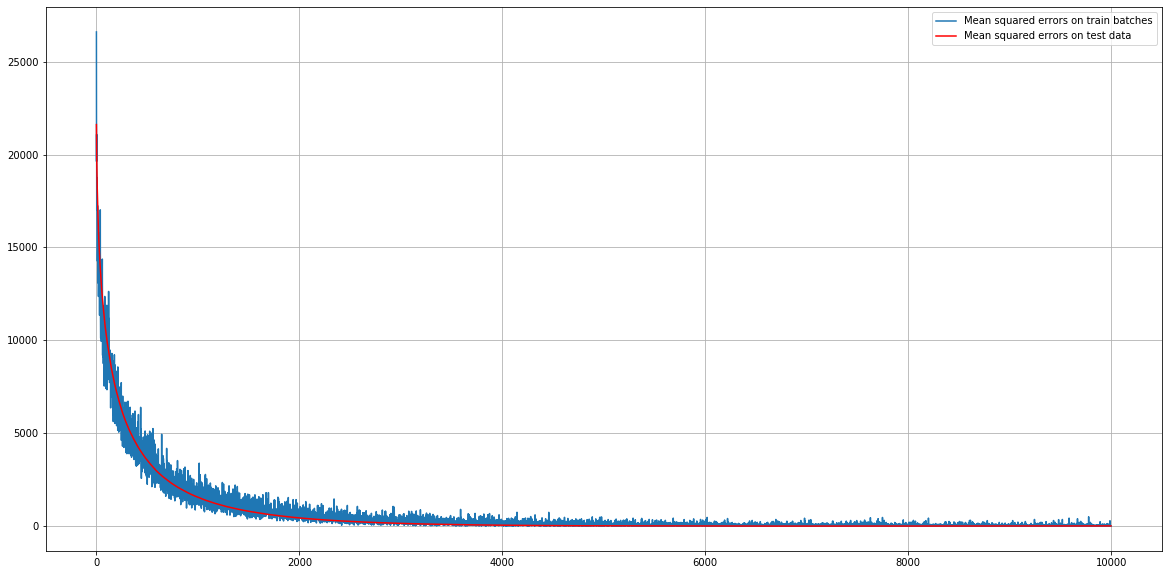

In [0]:
plt.figure(figsize=(20,10))
plt.plot(range(10000), linregr.train_errors_, label = "Mean squared errors on train batches")
plt.plot(range(10000), linregr.test_errors_, c='r', label = "Mean squared errors on test data")
plt.legend()
plt.grid()
plt.show()

#### 3.5.2 Scatter plot of predicted and true values

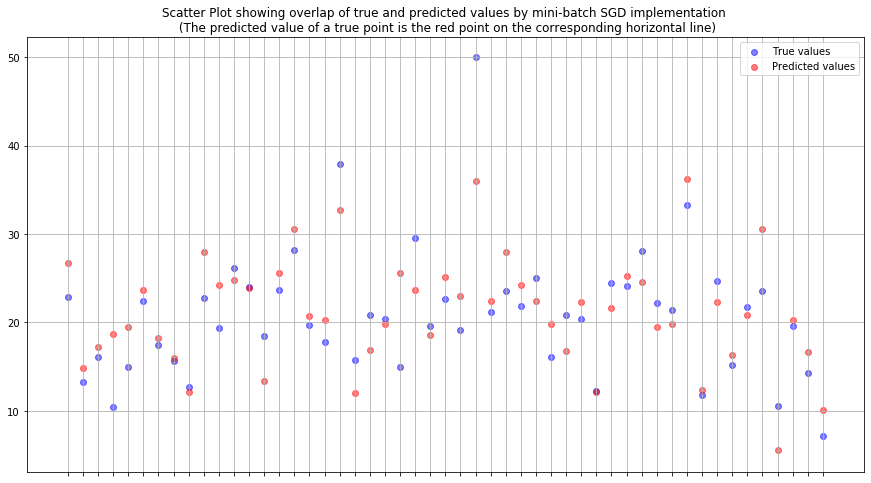

In [0]:
plt.figure(figsize=(15,8))
plt.scatter(range(len(test_y)), test_y, c='b', alpha=0.5, label="True values")
plt.scatter(range(len(test_y)), test_ypreds, c='r', alpha=0.5, label="Predicted values")
plt.title("Scatter Plot showing overlap of true and predicted values by mini-batch SGD implementation \n (The predicted value of a true point is the red point on the corresponding horizontal line)")
plt.xticks([x for x in range(0, len(test_y))], [])
plt.legend()
plt.grid()
plt.show()

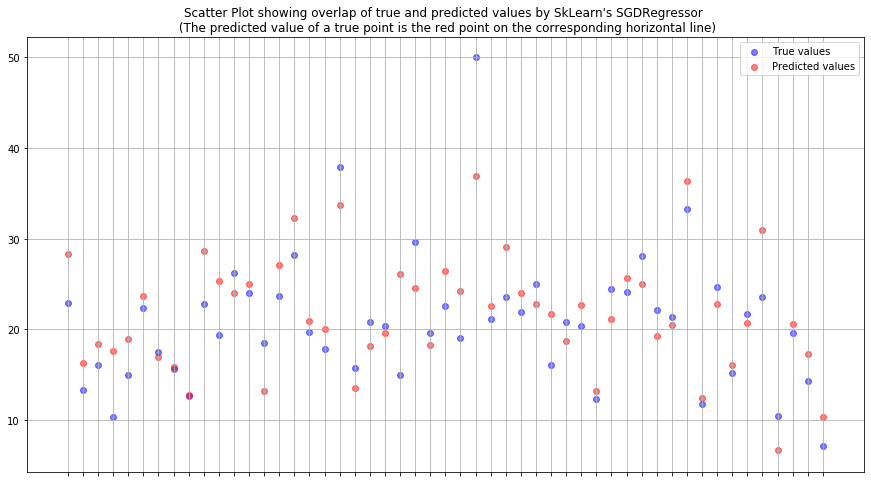

In [0]:
plt.figure(figsize=(15,8))
plt.scatter(range(len(test_y)), test_y, c='b', alpha=0.5, label="True values")
plt.scatter(range(len(test_y)), test_y_pred, c='r', alpha=0.5, label="Predicted values")
plt.title("Scatter Plot showing overlap of true and predicted values by SkLearn's SGDRegressor \n (The predicted value of a true point is the red point on the corresponding horizontal line)")
plt.xticks([x for x in range(0, len(test_y))], [])
plt.legend()
plt.grid()
plt.show()

#### 3.5.3 Mean Squared Errors in prediction by implemented SGD and Sklearn's SGD

In [0]:
mb_train_mse = mean_squared_error(train_y, train_ypreds)                       #MSE for predictions by Mini-batch SGD
mb_test_mse = mean_squared_error(test_y, test_ypreds)

sgd_train_mse = mean_squared_error(train_y, train_y_pred)                       #MSE for predictions by Sklearn's SGDRegressor
sgd_test_mse = mean_squared_error(test_y, test_y_pred)

In [0]:
table = PrettyTable()
table.field_names = ['Model', 'Hyper-parameters', 'Mean-Squared Error on Training data', 'Mean-Squared Error on Testing data']
table.add_row(['SkLearn SGDRegressor', 'Iterations: 10K  Eta0: 0.01', np.round(sgd_train_mse, 4), np.round(sgd_test_mse, 4)])
table.add_row(['Mini-batch SGD', 'Iterations: 10K  Eta0: 0.01', np.round(mb_train_mse, 4), np.round(mb_test_mse, 4)])

print(table)

+----------------------+-----------------------------+-------------------------------------+------------------------------------+
|        Model         |       Hyper-parameters      | Mean-Squared Error on Training data | Mean-Squared Error on Testing data |
+----------------------+-----------------------------+-------------------------------------+------------------------------------+
| SkLearn SGDRegressor | Iterations: 10K  Eta0: 0.01 |               22.6673               |               16.957               |
|    Mini-batch SGD    | Iterations: 10K  Eta0: 0.01 |               23.6521               |              16.2461               |
+----------------------+-----------------------------+-------------------------------------+------------------------------------+


## 4. Summary

Sklearn's implementation of SGDRegressor updates weights after randomly sampled datapoint, whereas in the above mini-batch SGD weights are updated only after predicting on a batch of datapoints. The two implementations show comparable performance on Boston Housing dataset with same hyper-parameters.